---
# About this project
As hospital data scientists, we aim to:
- Find factors that drive cost of hospitalisation cost for patients
- Find an effective way to estimate the hospitalisation cost for patients through modelling
    - Target performance (R2>90%, MAPE 10% or less)

## APPROACH
![](../images/overall_approach.jpg)

---
# About this notebook
This notebook focus on Cleaning and Processing the data, and analyse the data.

The aim for this notebook is to prepare model-ready data set with identification of potential key features for creating the model.

# Part 1: Library and Data Imports

In [1]:
import numpy as np 
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


#Visualisation:
import seaborn               as sns
import matplotlib.pyplot     as plt
sns.set_theme(style="whitegrid")

from tqdm import tqdm
tqdm.pandas()

import warnings
# Suppress the UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

#For importing/exporting data structures:
import pickle

In [2]:
from data_analysis import *

In [3]:
#Import csv files
demographic_df = pd.read_csv("../data_input/demographics.csv")
clinical_df = pd.read_csv("../data_input/clinical_data.csv")
billing_id_df = pd.read_csv("../data_input/bill_id.csv")
billing_amt_df = pd.read_csv("../data_input/bill_amount.csv")

---
# Part 2: Data Exploration and Processing

## 2.1 Quick overview of the data sets

In [4]:
df_names = "demographic_df,clinical_df,billing_id_df,billing_amt_df"
df_names = df_names.split(',')

In [5]:
df_names

['demographic_df', 'clinical_df', 'billing_id_df', 'billing_amt_df']

In [6]:
df_list = [demographic_df,clinical_df,billing_id_df,billing_amt_df]

In [7]:
for i in range(4):
    _df_ = df_list[i]
    print(F"DATAFRAME: {df_names[i]}")
    _df_.head(3)
    
    ID_col = [col for col in _df_.columns if ('id' in col) & ('resid' not in col)]
    for ID in ID_col:
        print(f"Number of unique {ID}: {_df_[ID].nunique()}")
    print(f"Dataframe size: {len(_df_)}")
    
    print("\n\n")
    

DATAFRAME: demographic_df


,patient_id,gender,race,resident_status,date_of_birth
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singaporean,1971-05-14
1,5b6477c5de78d0b138e3b0c18e21d0ae,f,Chinese,Singapore citizen,1976-02-18
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03


Number of unique patient_id: 3000
Dataframe size: 3000



DATAFRAME: clinical_df


,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,...,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,...,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0.0,0,0,0.0,0,0,...,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0.0,0,0,0.0,0,0,...,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0


Number of unique id: 3000
Dataframe size: 3400



DATAFRAME: billing_id_df


,bill_id,patient_id,date_of_admission
0,7968360812,1d21f2be18683991eb93d182d6b2d220,2011-01-01
1,6180579974,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
2,7512568183,1d21f2be18683991eb93d182d6b2d220,2011-01-01


Number of unique bill_id: 13600
Number of unique patient_id: 3000
Dataframe size: 13600



DATAFRAME: billing_amt_df


,bill_id,amount
0,40315104,1552.634830
1,2660045161,1032.011951
2,1148334643,6469.605351


Number of unique bill_id: 13600
Dataframe size: 13600





RENAME COLUMN NAME `amount` TO `hosp_bill`

In [8]:
# Billing amount is the primary interest in this project - we shall rename 'amount' as 'hospt_bill' for clarity
billing_amt_df.rename(columns = {'amount':'hosp_bill'},
                     inplace = True)

In [9]:
billing_amt_df.head(3)

,bill_id,hosp_bill
0,40315104,1552.634830
1,2660045161,1032.011951
2,1148334643,6469.605351


**Comments**

- There is 3000 unique patients
- There is 13600 unique bills
- However, there seems to have duplicated patient information in some dataframes (when number of unique ID does not match the size of the dataframe)
    - `clinical_df`
    - `billing_id_df`

We will now proceed to analyse these possible duplicates and check the IDs in each dataframes, before we merge the data sets.

## 2.2 Merging data sets

We will now proceed to merging the datasets to form `merged_df`, where each row represents each hospitalisation.

Part 1: Checking
1. IDs in each data frame
1. Analyse the duplicates in each dataframe

Part 2: Merging datasets

### 2.2.1 Checking `ID` and *Duplicates*

**CHECKING 'PATIENT ID' COLUMNS**
- We will be looking at three data sets: `clinical_df`, `demographic_df` and `billin_id_df`.
- Noticed each data set have consistent columns names for <code>bill_id</code> and <code>patient_id</code>, except <code>clinical_df</code> which only has one column called `id`.
- Based on earlier observation, we suspect `id` in `clinical_df` is referring to `patient_id`.

In [10]:
_no = demographic_df['patient_id'].nunique()
print(f"Number of unique patient_id in demographic_df = {_no}")

_no = billing_id_df['patient_id'].nunique()
print(f"Number of unique patient_id in clinical_df = {_no}")

_no = clinical_df['id'].nunique()
print(f"Number of unique id in clinical_df = {_no}")

Number of unique patient_id in demographic_df = 3000
Number of unique patient_id in clinical_df = 3000
Number of unique id in clinical_df = 3000


In [11]:
# Check if all three datasets have the same unique IDs
demographic_ids = set(demographic_df['patient_id'].unique())
billing_ids = set(billing_id_df['patient_id'].unique())
clinical_ids = set(clinical_df['id'].unique())

# Check if the intersection of all three sets has exactly 3000 elements
if len(demographic_ids & billing_ids & clinical_ids) == 3000:
    print("All three datasets have the same unique 3000 patient IDs.")
else:
    print("The datasets do not have the same unique 3000 patient IDs.")


All three datasets have the same unique 3000 patient IDs.


In [12]:
# We have confirmed `id` in clinical_df is `patient_id`
# As such, we shall rename 'id' in clinical_df to 'patient_id'
clinical_df.rename(columns = {'id':'patient_id'}, inplace = True)
clinical_df.head()

,patient_id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,...,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,...,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0.0,0,0,0.0,0,0,...,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0.0,0,0,0.0,0,0,...,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,0,1.0,No,0,0.0,1,1,...,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,0,0.0,No,0,0.0,1,1,...,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0


---
**CHECK 'BILL ID'**

In [13]:
# Check number of unique billing ids
for df in [billing_id_df, billing_amt_df]:
    print(df['bill_id'].nunique())

13600
13600


In [14]:
# Check if both datasets have the same unique Billing IDs
billing_ids = set(billing_id_df['bill_id'].unique())
billing_amt = set(billing_amt_df['bill_id'].unique())

## Check if the intersection of all three sets has exactly 13600 elements
if len(billing_ids & billing_amt) == 13600:
    print("Both datasets have the same unique 13600 billing IDs.")
else:
    print("The datasets do not have the same unique 13600 billing IDs.")

Both datasets have the same unique 13600 billing IDs.


---
**ANALYSE DUPLICATED ADMISSIONS INFORMATION IN `clinical_df`**<br>
We suspect that there are multiple data rows containing information for each admission.

In [15]:
#Number of unique patients
clinical_df['patient_id'].nunique()

3000

In [16]:
#Number of unique patient admissions
_d = clinical_df[['patient_id', 'date_of_admission']].copy()
_d['each_hospitalisation'] = _d['patient_id'] + _d['date_of_admission']
_d['each_hospitalisation'].nunique()

3400

In [17]:
#Checking if there is multiple data entries for each hospitalisation
clinical_df[['patient_id','date_of_admission']].duplicated().sum()

0

In [18]:
#Checking if there is multiple data entries for each patient
clinical_df['patient_id'].duplicated().sum()

400

In [19]:
clinical_df.shape

(3400, 26)

**Comments**

- There is 3000 unique patients, 3400 unique hospitalisations.
- There is no duplicated hospitalisations for each patient, meaning each data row represent each patient's independent admission
- We can interpret that there are `patients with multiple admissions`.

___
**ANALYSE DUPLICATED ADMISSIONS INFORMATION IN `billing_id_df`**<br>
We suspect that there are multiple data rows containing information for each admission.

In [20]:
#Number of unique patient admissions
_d = billing_id_df[['patient_id', 'date_of_admission']].copy()
_d['each_hospitalisation'] = _d['patient_id'] + _d['date_of_admission']
_d['each_hospitalisation'].nunique()

3400

In [21]:
#Checking if there is multiple data entries for each hospitalisation
billing_id_df[['patient_id','date_of_admission']].duplicated().sum()

10200

In [22]:
#Checking if there is multiple data entries for each patient
billing_id_df['patient_id'].duplicated().sum()

10600

In [23]:
billing_id_df.shape

(13600, 3)

**Comments**

- There is 3400 unique patients hospitalisations.
- There is multiple data rows for each patient, and each hospitalisation.
- We can interpret as there is total 3400 unique hospitalisation admissions in this billing_id_df, where there can be `multiple bills for each hospitalisation`.

___
#### 2.2.1 Summary:
- 3000 unique patients
- 3400 unique hospitalisations
- A patient may have multiple admissions in 2011-2015
- A patient may have multiple bilss in one admission

---
### 2.2.2 Merging the data

**MERGE BILLING DATASETS**<br>
We are going to create an aggregated dataframe that shows `total_hosp_bill` per hospitalisation.

In [24]:
#Number of columns in billing_id_df data set:
len(billing_id_df.columns)
billing_id_df.head(3)

3

,bill_id,patient_id,date_of_admission
0,7968360812,1d21f2be18683991eb93d182d6b2d220,2011-01-01
1,6180579974,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
2,7512568183,1d21f2be18683991eb93d182d6b2d220,2011-01-01


In [25]:
#Number of columns in billing_amt_df data set:
len(billing_amt_df.columns)
billing_amt_df.head(3)

2

,bill_id,hosp_bill
0,40315104,1552.634830
1,2660045161,1032.011951
2,1148334643,6469.605351


In [26]:
#Merge the billing data sets first, expected to have 4 columns
billing_merged_df = billing_id_df.merge(billing_amt_df, on='bill_id')
billing_merged_df.head()

,bill_id,patient_id,date_of_admission,hosp_bill
0,7968360812,1d21f2be18683991eb93d182d6b2d220,2011-01-01,951.214467
1,6180579974,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,19900.297086
2,7512568183,1d21f2be18683991eb93d182d6b2d220,2011-01-01,12338.269972
3,3762633379,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,1145.372193
4,7654730355,1d21f2be18683991eb93d182d6b2d220,2011-01-01,1133.601902


In [27]:
billing_merged_df.columns

Index(['bill_id', 'patient_id', 'date_of_admission', 'hosp_bill'], dtype='object')

In [28]:
#Process the dataframe, so that each data row represent each hospitalisation, and the hosp_bills is aggregated to total_hosp_bill

# Group the data by 'patient_id' and 'date_of_admission' and calculate the sum of 'hosp_bill'
grouped_df = billing_merged_df.groupby(['patient_id', 'date_of_admission'])['hosp_bill'].sum().reset_index()

# Create a new DataFrame with the desired columns
bill_df = grouped_df[['patient_id', 'date_of_admission', 'hosp_bill']].copy()
bill_df.columns = ['patient_id', 'date_of_admission', 'total_hosp_bill']

# Display the resulting DataFrame, there should be 3400 data rows
bill_df.head()
bill_df.shape

,patient_id,date_of_admission,total_hosp_bill
0,00225710a878eff524a1d13be817e8e2,2014-04-10,5190.566695
1,0029d90eb654699c18001c17efb0f129,2012-11-07,22601.497872
2,0040333abd68527ecb53e1db9073f52e,2013-01-19,17447.181635
3,00473b58e3dc8ae37b3cb34069705083,2014-02-10,15285.883220
4,0078662d1d983dde68ea057c42d5b5cf,2012-04-28,73477.869010


(3400, 3)

**MERGE BILLING DATASET TO CLINICAL DATASET**

In [29]:
#Merge the billing dataframe with the clinical data set
hospitalisation_df = bill_df.merge(clinical_df, on=['patient_id', 'date_of_admission'])
hospitalisation_df.head()

,patient_id,date_of_admission,total_hosp_bill,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,...,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
0,00225710a878eff524a1d13be817e8e2,2014-04-10,5190.566695,2014-04-22,0,0.0,0,0,0.0,0,...,0,0,1,0,0,13.4,27.9,96.0,66.9,155.0
1,0029d90eb654699c18001c17efb0f129,2012-11-07,22601.497872,2012-11-20,0,1.0,0,0,0.0,1,...,0,1,0,0,1,16.7,26.5,109.0,89.1,160.0
2,0040333abd68527ecb53e1db9073f52e,2013-01-19,17447.181635,2013-01-31,0,1.0,0,0,0.0,0,...,0,1,0,0,1,14.8,25.2,96.0,79.5,172.0
3,00473b58e3dc8ae37b3cb34069705083,2014-02-10,15285.883220,2014-02-15,1,0.0,0,0,0.0,0,...,0,1,1,1,0,14.9,28.7,122.0,81.1,160.0
4,0078662d1d983dde68ea057c42d5b5cf,2012-04-28,73477.869010,2012-05-10,0,1.0,No,0,0.0,1,...,0,1,0,1,1,14.2,27.2,89.0,74.7,173.0


In [30]:
exp = len(clinical_df.columns) + len(bill_df.columns) - 2
actual = len(hospitalisation_df.columns)
print(f"""
Expected number of columns in hospitalisation_df: {exp}
Number of hospitalisation_df columns: {actual}""")

if exp == actual:
    print("Number of columns in resulting dataframe matches expected number of columns")
    
if len(hospitalisation_df) == len(bill_df):
    print(f"Number of rows in resulting dataframe matches expected number of columns of {len(bill_df)}")


Expected number of columns in hospitalisation_df: 27
Number of hospitalisation_df columns: 27
Number of columns in resulting dataframe matches expected number of columns
Number of rows in resulting dataframe matches expected number of columns of 3400


**MERGE hospitalisation_df DATASETS WITH DEMOGRAPHIC DATASET**

In [31]:
#Merge the hospitalisation_df dataframe with the patient demographic data set
merged_df = hospitalisation_df.merge(demographic_df, on='patient_id', how='left')
merged_df.head()

,patient_id,date_of_admission,total_hosp_bill,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,...,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth
0,00225710a878eff524a1d13be817e8e2,2014-04-10,5190.566695,2014-04-22,0,0.0,0,0,0.0,0,...,0,13.4,27.9,96.0,66.9,155.0,Female,Chinese,Singaporean,1983-01-16
1,0029d90eb654699c18001c17efb0f129,2012-11-07,22601.497872,2012-11-20,0,1.0,0,0,0.0,1,...,1,16.7,26.5,109.0,89.1,160.0,Female,Chinese,Singaporean,1943-10-14
2,0040333abd68527ecb53e1db9073f52e,2013-01-19,17447.181635,2013-01-31,0,1.0,0,0,0.0,0,...,1,14.8,25.2,96.0,79.5,172.0,Male,India,Singaporean,1972-08-26
3,00473b58e3dc8ae37b3cb34069705083,2014-02-10,15285.883220,2014-02-15,1,0.0,0,0,0.0,0,...,0,14.9,28.7,122.0,81.1,160.0,Female,Chinese,Singapore citizen,1976-07-23
4,0078662d1d983dde68ea057c42d5b5cf,2012-04-28,73477.869010,2012-05-10,0,1.0,No,0,0.0,1,...,1,14.2,27.2,89.0,74.7,173.0,Male,Malay,Foreigner,1942-10-19


In [32]:
exp = len(hospitalisation_df.columns) + len(demographic_df.columns) - 1
actual = len(merged_df.columns)
print(f"""
Expected number of columns in merged_df: {exp}
Number of merged_df columns: {actual}\n""")

if exp == actual:
    print("Number of columns in resulting dataframe is the same as expected number of columns")
if len(merged_df) == len(hospitalisation_df):
    print(f"Number of rows in resulting dataframe matches expected number of columns of {len(hospitalisation_df)}")


Expected number of columns in merged_df: 31
Number of merged_df columns: 31

Number of columns in resulting dataframe is the same as expected number of columns
Number of rows in resulting dataframe matches expected number of columns of 3400


---
#### 2.2.2 Summary:
We have merged the three datasets together:
- each row represent each hospitalisation case
- bill reflected is the total bill per hospitalisation

---
## 2.3 View merged dataset
Identify concerns to investigate further to ensure data is clean.

In [33]:
df_summary(merged_df, "Merged Dataframe")

Dataframe (Merged Dataframe) Summary
Shape(col,rows): (3400, 31)
Number of duplicates: 0
------------------------------------------------------------
Number of each unique datatypes:
int64      15
object      8
float64     8
dtype: int64
------------------------------------------------------------
Columns with missing values:
                 col  num_nulls  perc_null
0  medical_history_2        233       0.07
1  medical_history_5        304       0.09
------------------------------------------------------------
Check Quantitative data values:
           Column Name  Minimum Value  Maximum Value
0      total_hosp_bill    2946.100354   98723.854994
1    medical_history_1       0.000000       1.000000
2    medical_history_2       0.000000       1.000000
3    medical_history_4       0.000000       1.000000
4    medical_history_5       0.000000       1.000000
5    medical_history_6       0.000000       1.000000
6    medical_history_7       0.000000       1.000000
7   preop_medication_1    

In [34]:
#There should be no duplicated patient_id and hospitalisation admissions
#Number of unique patient admissions
_d = merged_df[['patient_id', 'date_of_admission']].copy()
_d['each_hospitalisation'] = _d['patient_id'] + _d['date_of_admission']
_d['each_hospitalisation'].nunique()

3400

**Remarks**

We have succesfully merged the data sets, where each row now represents each unique hospitalisation.<br>
Below is the description of identified concerns to investigate subsequently during data cleaning.

|**Observation**|**Description**|**Plan**|
|---|---|---|
|General|<ul><li>3000 unique patients<li>3400 hospitalisation cases|*NA*|
|Missing Data|<ul><li>Missing data noted:<ul><li>`medical_history_2`<li>`medical_history_5`|Analyse the columns with missing data, possibly impute with appropriate values|
|Duplicate Data|<ul><li>Absent |*NA*|
|Data Type|<ul><li>Some features data types look into:<ul><li>`medical_history_3` (Suspect presence of non-numerical elements in the column)<li>'date' related columns (To convert to date_time format)<li>boolean columns to be in interger form|*Refer to comments in brackets in the column on the left*|
|Data Values|<ul><li>Some features data types focus into:<ul><li>`gender` (There are 4 genders in the data)<li>`medical_history_3` (Suspect presence of non-numerical elements in the column)|Shall address data types first.<br><br>To look into the data range for quantitative data and the unique elements in qualitative data.|

---
## 2.4 Missing Data 
Investigate and address missing data

In [35]:
df_missing(merged_df)

,col,num_nulls,perc_null
0,medical_history_2,233,0.07
1,medical_history_5,304,0.09


**Comments**:<br>
* Missing data is found in columns about `medical history`.
* As it is not known what medical history column are refering too, it is reasonable to assume patient do not have the medical history if it is not being recorded.
* As such we shall fill NaN with '0'.

In [36]:
merged_df[['medical_history_5','medical_history_2']] = merged_df[['medical_history_5','medical_history_2']].fillna(0)

_if_missing = df_missing(merged_df)
if _if_missing.empty:
    print("No missing data")
else:
    print (_if_missing)

No missing data


---
## 2.5 Address Data type
Some features data types look into:
* 'date' related columns (To convert to date_time format)
* `medical_history_3` (Suspect presence of non-numerical elements in the column)
* boolean columns to be in interger form

### 2.5.1 Date-related columns
To convert to `datetime` format

In [37]:
date_col = [col for col in merged_df.columns if 'date' in col]
merged_df[date_col].head()

,date_of_admission,date_of_discharge,date_of_birth
0,2014-04-10,2014-04-22,1983-01-16
1,2012-11-07,2012-11-20,1943-10-14
2,2013-01-19,2013-01-31,1972-08-26
3,2014-02-10,2014-02-15,1976-07-23
4,2012-04-28,2012-05-10,1942-10-19


In [38]:
for col in date_col:
    merged_df[col] = pd.to_datetime(merged_df[col], yearfirst = True)
merged_df[date_col].head()    

,date_of_admission,date_of_discharge,date_of_birth
0,2014-04-10,2014-04-22,1983-01-16
1,2012-11-07,2012-11-20,1943-10-14
2,2013-01-19,2013-01-31,1972-08-26
3,2014-02-10,2014-02-15,1976-07-23
4,2012-04-28,2012-05-10,1942-10-19


In [39]:
#Checking they have been converted to datetime datatype format
merged_df[date_col].dtypes

date_of_admission    datetime64[ns]
date_of_discharge    datetime64[ns]
date_of_birth        datetime64[ns]
dtype: object

### 2.5.2 <code>'medical_history_3'</code> column
To convert to `interger` format.
However, we first need to check for non-numerical elements.

In [40]:
merged_df['medical_history_3'].unique()

array(['0', 'No', '1', 'Yes'], dtype=object)

In [41]:
merged_df['medical_history_3'] = merged_df['medical_history_3'].replace({'No': '0', 'Yes': '1'})
merged_df['medical_history_3'] = merged_df['medical_history_3'].astype(int)

In [42]:
#Check it has been changed to interger form
merged_df['medical_history_3'].dtype

dtype('int32')

### 2.5.3 Boolean column
To convert to `interger` format.

*Based on observation, it appear `medical history`, `pre-op medication` and `symptom` are boolean columns.*

In [43]:
bool_col = [col for col in merged_df.columns if ('medic' in col) or ('sympt' in col)]
merged_df[bool_col] = merged_df[bool_col].astype(int)

In [44]:
#check if datatype is now 'int'
merged_df[bool_col].dtypes

medical_history_1     int32
medical_history_2     int32
medical_history_3     int32
medical_history_4     int32
medical_history_5     int32
medical_history_6     int32
medical_history_7     int32
preop_medication_1    int32
preop_medication_2    int32
preop_medication_3    int32
preop_medication_4    int32
preop_medication_5    int32
preop_medication_6    int32
symptom_1             int32
symptom_2             int32
symptom_3             int32
symptom_4             int32
symptom_5             int32
dtype: object

### 2.5.4 View columns data types

In [45]:
#datetime columns
merged_df.select_dtypes(include = 'datetime').dtypes

date_of_admission    datetime64[ns]
date_of_discharge    datetime64[ns]
date_of_birth        datetime64[ns]
dtype: object

In [46]:
#numerical columns
merged_df.select_dtypes(include = ['float','int']).dtypes

total_hosp_bill       float64
medical_history_1       int32
medical_history_2       int32
medical_history_3       int32
medical_history_4       int32
medical_history_5       int32
medical_history_6       int32
medical_history_7       int32
preop_medication_1      int32
preop_medication_2      int32
preop_medication_3      int32
preop_medication_4      int32
preop_medication_5      int32
preop_medication_6      int32
symptom_1               int32
symptom_2               int32
symptom_3               int32
symptom_4               int32
symptom_5               int32
lab_result_1          float64
lab_result_2          float64
lab_result_3          float64
weight                float64
height                float64
dtype: object

In [47]:
#object columns
merged_df.select_dtypes(include = 'object').dtypes

patient_id         object
gender             object
race               object
resident_status    object
dtype: object

**Comments**:<br>
Datatypes all appear appropriate.

---
#### 2.5.4 Summary
1. Converted `data` columns to date_time datatype
1. Cleaned and converted `medical_history_3` to integer type
1. Converted other Boolean-type columns to interger data type
1. All column data type checked

---
## 2.6 Data Values/ Elements
Check if data values/elements make logical sense.<br>

### 2.6.1 Qualitative Data
We will check the unique elements in these data columns.

In [48]:
obj_col = ['gender', 'race', 'resident_status']
for obj in obj_col:
    print(f"{obj} unique elements:\n  {merged_df[obj].unique()}")

gender unique elements:
  ['Female' 'Male' 'm' 'f']
race unique elements:
  ['Chinese' 'India' 'Malay' 'Others' 'Indian' 'chinese']
resident_status unique elements:
  ['Singaporean' 'Singapore citizen' 'Foreigner' 'PR']


In [49]:
# Standardizing data elements in respective columns
merged_df['gender'] = merged_df['gender'].replace({'m': 'Male',
                                                   'f': 'Female'})
merged_df['race'] = merged_df['race'].replace({'chinese': 'Chinese',
                                               'India':'Indian'})
merged_df['resident_status'] = merged_df['resident_status'].replace({'Singaporean': 'Singapore citizen'})

In [50]:
obj_col = ['gender', 'race', 'resident_status']
for obj in obj_col:
    print(f"{obj} unique elements:\n  {merged_df[obj].unique()}")

gender unique elements:
  ['Female' 'Male']
race unique elements:
  ['Chinese' 'Indian' 'Malay' 'Others']
resident_status unique elements:
  ['Singapore citizen' 'Foreigner' 'PR']


**Comments**:<br>
Unique data elements in each categorical columns are logical and appropriate.

### 2.6.2 Quantitative Data

In [51]:
get_min_max_df(merged_df.select_dtypes(exclude = 'object'))

,Column Name,Minimum Value,Maximum Value
0,date_of_admission,2011-01-01 00:00:00,2015-12-28 00:00:00
1,total_hosp_bill,2946.100354,98723.854994
2,date_of_discharge,2011-01-11 00:00:00,2016-01-11 00:00:00
3,medical_history_1,0,1
4,medical_history_2,0,1
5,medical_history_3,0,1
6,medical_history_4,0,1
7,medical_history_5,0,1
8,medical_history_6,0,1
9,medical_history_7,0,1


In [52]:
#Data that is boolean in nature:
bool_col = [col for col in merged_df.columns if ('medic' in col) or ('sympt' in col)]
for col in bool_col:
    n = 0
    if merged_df[col].nunique() > 2:
        print(f"{col} unique elements: {merged_df[col].unique()}")
        n =+ 1
if n == 0:
    print("They all have only 2 unique values")

They all have only 2 unique values


**Comments**:<br>
* Min and Max values for most columns follow logical sense
     * Unable to comment the same way for <code>lab_result</code> columns as there is no understanding what are their normal value range.
* Boolean-columns have only two unique values - '0' and '1'

---
### 2.6 Summary
- Unique elements of categorical columns checked, including boolean columns
- Range of quatitative columns checked
---
## Summary of the Data Processing
![](../images/data_summary.jpg)

---
# Part 3: Analysis

## 3.1 Univariate Analysis

Conduct analysis on individual features

### 3.1.1 Demographic Analysis

#### 3.1.1.1 GENDER, RACE, RESIDENTIAL STATUS

We will be analysing the demographics of the 3000 indepent patients, as some patients have multiple admissions.
We will also be analysing the demographics across all 3400 hospitalisation cases, as it is possible some demographic group may be hospitalised more often than the other.

In [53]:
#Obtaining a subset dataset of the 3000 unique patients
subset_df = merged_df.copy()
subset_df = subset_df.loc[:,['patient_id','gender','race','resident_status']]
subset_df.drop_duplicates(inplace=True)
subset_df.shape
subset_df.head(3)

(3000, 4)

,patient_id,gender,race,resident_status
0,00225710a878eff524a1d13be817e8e2,Female,Chinese,Singapore citizen
1,0029d90eb654699c18001c17efb0f129,Female,Chinese,Singapore citizen
2,0040333abd68527ecb53e1db9073f52e,Male,Indian,Singapore citizen


In [54]:
#ACROSS THE 3000 UNIQUE PATIENTS

# Calculate count and percentage values for 'gender'
gender_counts = subset_df['gender'].value_counts()
gender_percentages = subset_df['gender'].value_counts(normalize = True)*100

# Calculate count and percentage values for 'race'
race_counts = subset_df['race'].value_counts()
race_percentages = subset_df['race'].value_counts(normalize = True)*100

# Calculate count and percentage values for 'resident_status'
resident_status_counts = subset_df['resident_status'].value_counts()
resident_status_percentages = subset_df['resident_status'].value_counts(normalize = True)*100

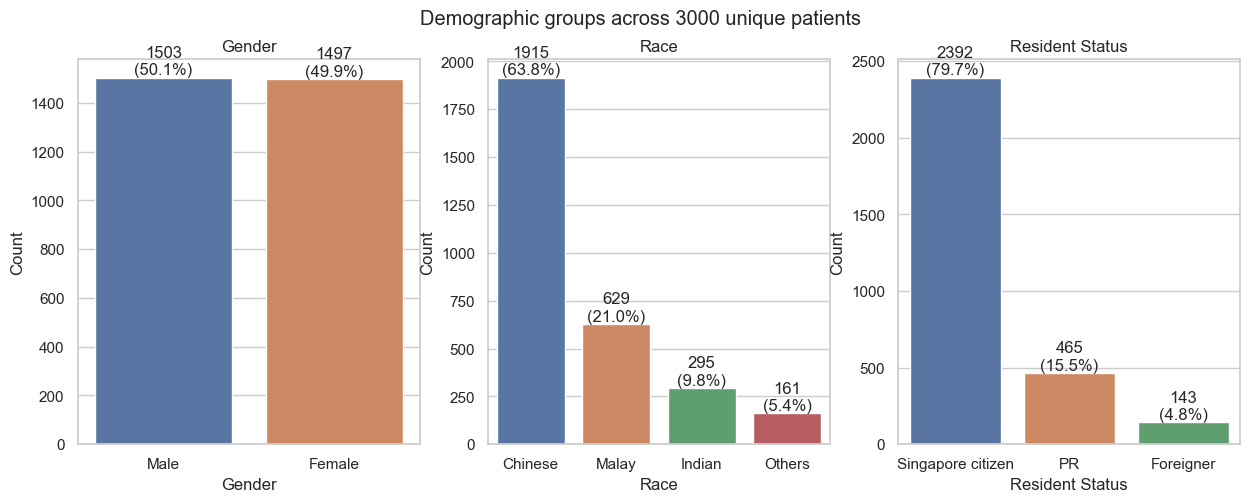

In [55]:
# Create subplots to display multiple countplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

labels = ["Gender","Race","Resident Status"]
columns = ['gender','race', 'resident_status']
counts = [gender_counts,race_counts,resident_status_counts]
perctages = [gender_percentages, race_percentages, resident_status_percentages]

for i in range(3):
    feature = columns[i]
    count = counts[i]
    perc = perctages[i]
    
    #each subplot
    sns.countplot(data=subset_df,
              x=feature,
              order = count.index,
              ax=axes[i])
    
    #subplot labels
    label = labels[i]
    axes[i].set_ylabel('Count')
    axes[i].set_title(label)
    axes[i].set_xlabel(label)
    
    #subplot annotation
    for j, count in enumerate(count):
        axes[i].text(j, count, f"{count}\n({perc[j]:.1f}%)",
                     ha='center', va='bottom') 

plt.suptitle('Demographic groups across 3000 unique patients')
plt.show();

In [56]:
#ACROSS THE 3400 UNIQUE HOSPITALISATION CASES

# Calculate count and percentage values for 'gender'
gender_counts = merged_df['gender'].value_counts()
gender_percentages = merged_df['gender'].value_counts(normalize = True)*100

# Calculate count and percentage values for 'race'
race_counts = merged_df['race'].value_counts()
race_percentages = merged_df['race'].value_counts(normalize = True)*100

# Calculate count and percentage values for 'resident_status'
resident_status_counts = merged_df['resident_status'].value_counts()
resident_status_percentages = merged_df['resident_status'].value_counts(normalize = True)*100

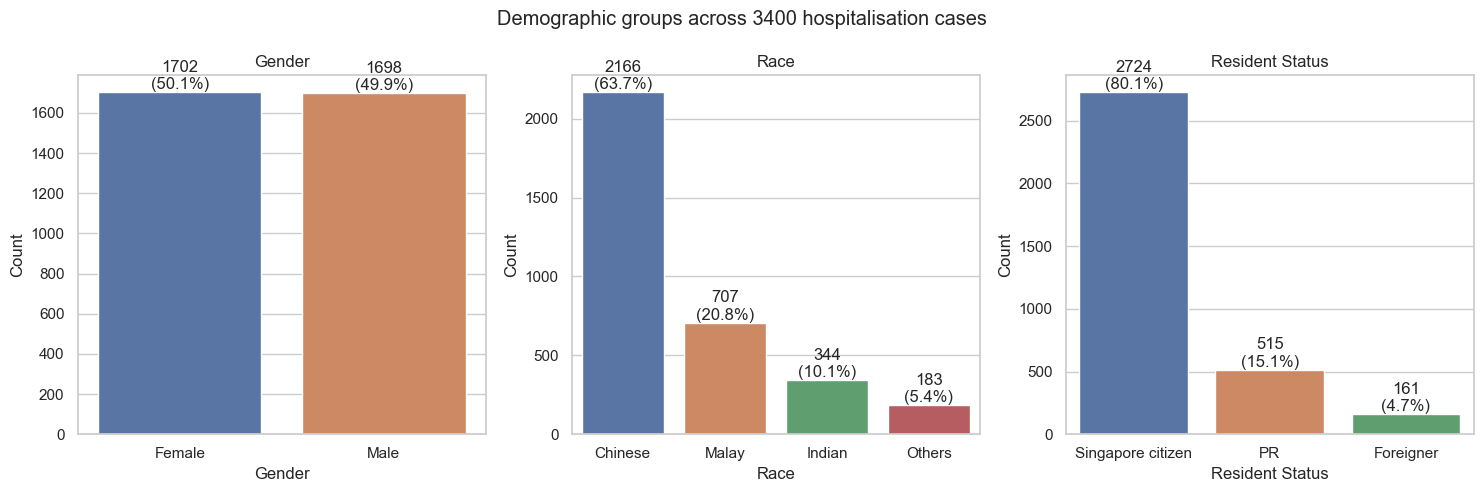

In [57]:
# Create subplots to display multiple countplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

labels = ["Gender","Race","Resident Status"]
columns = ['gender','race', 'resident_status']
counts = [gender_counts,race_counts,resident_status_counts]
perctages = [gender_percentages, race_percentages, resident_status_percentages]

for i in range(3):
    feature = columns[i]
    count = counts[i]
    perc = perctages[i]
    
    #each subplot
    sns.countplot(data=merged_df,
              x=feature,
              order = count.index,
              ax=axes[i])
    
    #subplot labels
    label = labels[i]
    axes[i].set_ylabel('Count')
    axes[i].set_title(label)
    axes[i].set_xlabel(label)
    
    #subplot annotation
    for j, count in enumerate(count):
        axes[i].text(j, count, f"{count}\n({perc[j]:.1f}%)",
                     ha='center', va='bottom') 

plt.suptitle('Demographic groups across 3400 hospitalisation cases')
plt.tight_layout()
plt.show();


**Comments**<br>
|Feature|Observation|Remarks|
|---|---|---|
|Demographic distribution|Similar when analysis done on 3000 unique patients and on 3400unique hospitalisation cases||
|Gender|Relatively balanced (50.1% : 49.9%)||
|Race|Chinese appears to be dominant racial group (63.7%)|Racial profile may influence hospitalisation bill because:<br><li>Difference ethinicities predispose individuals to certain medical conditions ([reference](https://www.singhealth.com.sg/news/tomorrows-medicine/new-study-uncovers-genetic-risks-of-getting-disease-among-different-ethnicities-in-singapore))<li>Hospitalisation bill is influenced by the treatment received for medical conditions<li>It is possible we may observe a particular ethnic group tend to have higher/lower bill as a result of particular disease conditions that the ethnic group tends to have.|
|Resident Status|Singapore citizen  appears to be dominant group (80.1%)|Resident status have influence on hospitalisation bill, as it determines if the individual is eligible for government subsidies ([reference](https://www.guidemesingapore.com/business-guides/immigration/get-to-know-singapore/healthcare-in-singapore))
    
To analyse hospitalisation bill among the different categorical groups later.

#### 3.1.1.2 PATIENT AGE

In [58]:
merged_df['Age_upon_admission'] = merged_df['date_of_admission'].dt.year - merged_df['date_of_birth'].dt.year

In [59]:
_ls = date_col + ['Age_upon_admission']
merged_df[_ls]

,date_of_admission,date_of_discharge,date_of_birth,Age_upon_admission
0,2014-04-10,2014-04-22,1983-01-16,31
1,2012-11-07,2012-11-20,1943-10-14,69
2,2013-01-19,2013-01-31,1972-08-26,41
3,2014-02-10,2014-02-15,1976-07-23,38
4,2012-04-28,2012-05-10,1942-10-19,70
...,...,...,...,...
3395,2011-04-24,2011-05-04,1976-08-07,35
3396,2015-11-28,2015-12-07,1963-10-07,52
3397,2013-05-05,2013-05-15,1938-09-12,75
3398,2012-12-24,2013-01-01,1950-06-06,62


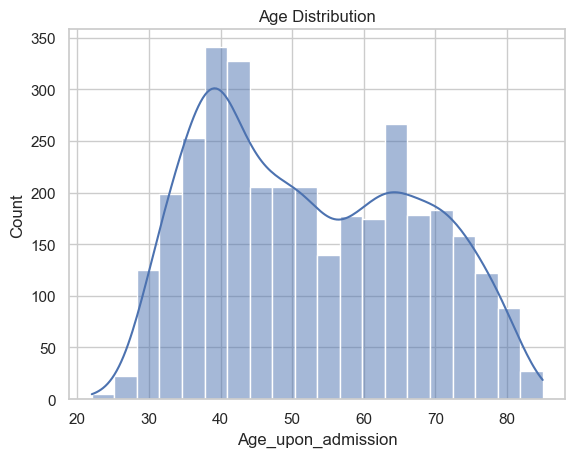

In [60]:
sns.histplot(data = merged_df,
            x = 'Age_upon_admission',
            bins= 20,
            kde=True)
plt.title("Age Distribution");

In [61]:
merged_df['Age_upon_admission'].describe()

count    3400.000000
mean       52.542647
std        14.681475
min        22.000000
25%        40.000000
50%        51.000000
75%        65.000000
max        85.000000
Name: Age_upon_admission, dtype: float64

**Comment**

|Observation|Description|
|---|---|
|From the histogram we observe a bimodal distribution in age, suggesting there is generally two groups of patients.|One younger group (22-55yo) with mean age around 40 years old, and another older group (55-85yo) with mean around 66 years old.|
|Middle-age patients dominates over younger and older patients|Younger patients (20s-30s) and Senior patients (above 65yo) makes up 25% each, while middle-age patients (40s-mid60s) makes up about 50%|

In subsequent analysis, we may explore how age influence hospitalisation bill. It is possible patients greater in age have more complex medical conditions that require multiple medical interventions. 

### 3.1.2 Hospitalisation Bill and Duration Analysis

#### 3.1.2.1 HOSPITALISATION BILL

In [62]:
merged_df['total_hosp_bill'].describe()

count     3400.000000
mean     21859.071130
std      10155.336753
min       2946.100354
25%      14793.370831
50%      20180.020614
75%      26680.292435
max      98723.854994
Name: total_hosp_bill, dtype: float64

In [63]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test
statistic, p_value = shapiro(merged_df['total_hosp_bill'])

# Print the results
print(f"Shapiro-Wilk statistic: {statistic}")
print(f"P-value: {round(p_value, 5)}")
if p_value<0.05:
    print("The variable DOES NOT follows a Normal Distribution")

Shapiro-Wilk statistic: 0.8979097604751587
P-value: 0.0
The variable DOES NOT follows a Normal Distribution


In [64]:
#Outlier detection, applying Tukey’s fences concept.
_bill = merged_df['total_hosp_bill']
q1=_bill.quantile(0.25)
q3=_bill.quantile(0.75)
IQR=q3-q1
upper_fence = q3+1.5*IQR
lower_fence = q1-1.5*IQR

In [65]:
upper_fence

44510.674840263746

In [66]:
lower_fence

-3037.0115738342465

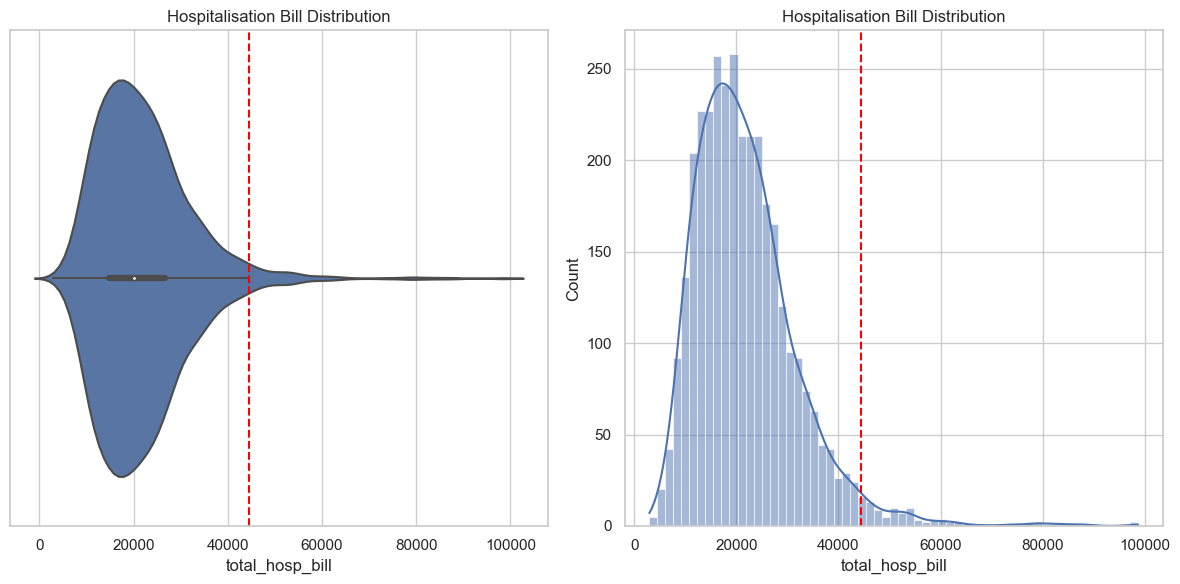

In [67]:
# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first subplot (Violinplot)
sns.violinplot(data=merged_df, x='total_hosp_bill', ax=axs[0])
axs[0].set_title("Hospitalisation Bill Distribution")
axs[0].axvline(x=upper_fence, color='red', linestyle='--')

# Plot the second subplot (Histogram with KDE)
sns.histplot(data=merged_df, x='total_hosp_bill', kde=True, ax=axs[1])
axs[1].set_title("Hospitalisation Bill Distribution")
axs[1].axvline(x=upper_fence, color='red', linestyle='--')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show();


In [68]:
#Number of hospital bills that are above upper fence (outliers)

_cond = merged_df['total_hosp_bill'] > upper_fence
no = len(merged_df[_cond])
perc = (no/len(merged_df))*100
print(f"""
Number of outlier bills: {no}
Percentage of outlier bills: {np.round(perc, 2)}%""")



Number of outlier bills: 94
Percentage of outlier bills: 2.76%


**Comments**

- The hospitalisation bill distribution is <code>positively skewed</code> as the histogram shows it tails off on the right.
- As the Shapiro-Wilk test shows p<0.05, we reject the null hypothesis that the distribution is normal.
    - The hospitalisation bill DOES NOT follows a normal distribution.
    - This makes sense as well as the distribution is not centred around the mean, and the shape of the distribution is not symmetrical too.
- The bill ranges from \~\\$2.9K to \~\\$99K.
- Average bill is about \\$20K.
- 2.8% of the bill is very large and are outliers (\>\\$44.5K)


[Reference for interpretatin violinplot](https://towardsdatascience.com/violin-plots-explained-fb1d115e023d)<br>
![](../images/violinplot_img.jpg)



#### 3.1.2.1 HOSPITALISATION PERIOD

In [69]:
merged_df['hospitalization_duration_days'] = (merged_df['date_of_discharge'] - merged_df['date_of_admission']).dt.days

_col = ['hospitalization_duration_days', 'date_of_admission', 'date_of_discharge']
merged_df[_col].tail()

,hospitalization_duration_days,date_of_admission,date_of_discharge
3395,10,2011-04-24,2011-05-04
3396,9,2015-11-28,2015-12-07
3397,10,2013-05-05,2013-05-15
3398,8,2012-12-24,2013-01-01
3399,11,2013-06-04,2013-06-15


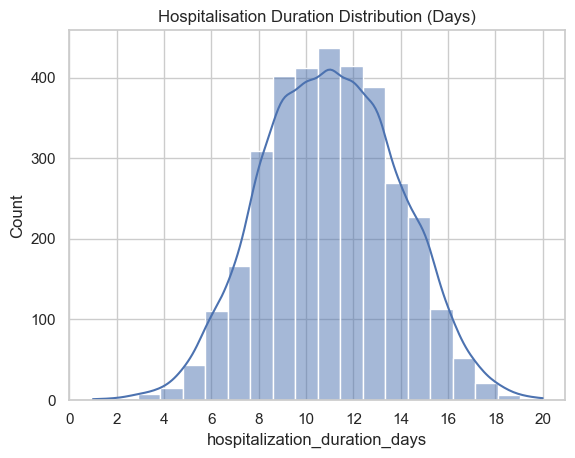

In [70]:
sns.histplot(data = merged_df,
            x = 'hospitalization_duration_days',
             bins = 20,
            kde=True)
plt.title("Hospitalisation Duration Distribution (Days)")
plt.xticks(range(0, merged_df['hospitalization_duration_days'].max() + 1, 2));

In [71]:
merged_df['hospitalization_duration_days'].describe()

count    3400.000000
mean       11.051176
std         2.850140
min         1.000000
25%         9.000000
50%        11.000000
75%        13.000000
max        20.000000
Name: hospitalization_duration_days, dtype: float64

In [72]:
get_min_max_df(merged_df[['date_of_admission','date_of_discharge']])

,Column Name,Minimum Value,Maximum Value
0,date_of_admission,2011-01-01,2015-12-28
1,date_of_discharge,2011-01-11,2016-01-11


**Comments**<br>
- The data consist of hospitalisations of patients admitted between 2011 to 2015.
- Hospitalisation duration range from 1 day to 20 days.
- Most patients hospitalisation duration is around 1 to 2 weeks.

#### 3.1.2.3 NO. OF PREVIOUS ADMISSIONS
Some patients have multiple admissions between 2011-2015.<br>
We will now be looking to see how many patients have multiple admissions, and how many admissions these patients had.

In [73]:
hosp_count = merged_df.groupby('patient_id')['date_of_admission'].count()
hosp_count.describe()

count    3000.000000
mean        1.133333
std         0.360923
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: date_of_admission, dtype: float64

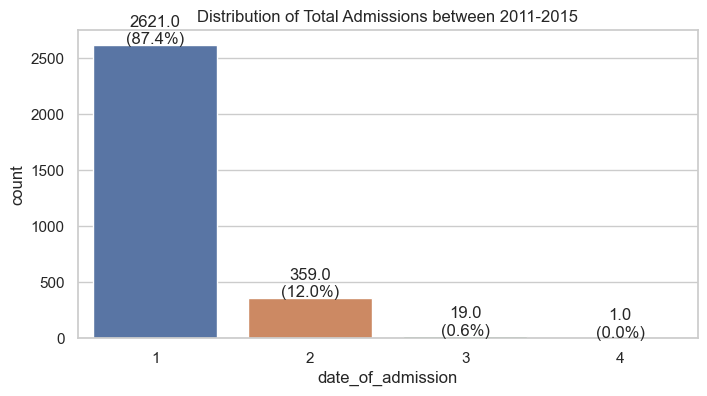

In [74]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x = hosp_count)
total = len(hosp_count)

for p in ax.patches:
    count = p.get_height()
    percentage = count / total * 100
    ax.annotate(f'{count}\n({percentage:.1f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')
plt.title("Distribution of Total Admissions between 2011-2015")
# Display the plot
plt.show();

In [75]:
#Look at patient with 3 or more admissions between 2011-2015
id_3 = hosp_count[hosp_count>=3].index.tolist()
merged_df[merged_df['patient_id'].isin(id_3)]

,patient_id,date_of_admission,total_hosp_bill,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,...,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth,Age_upon_admission,hospitalization_duration_days
200,0eacfb2daed1f3ba2adf32e293bc05a6,2012-07-12,11388.371222,2012-07-26,0,1,0,0,1,1,...,23.9,87.0,76.8,168.0,Female,Chinese,Singapore citizen,1979-05-12,33,14
201,0eacfb2daed1f3ba2adf32e293bc05a6,2014-01-28,19192.787251,2014-02-09,0,0,0,0,0,1,...,22.6,109.0,76.8,168.0,Female,Chinese,Singapore citizen,1979-05-12,35,12
202,0eacfb2daed1f3ba2adf32e293bc05a6,2014-03-25,12757.961572,2014-04-02,0,0,0,0,0,0,...,23.2,107.0,78.8,168.0,Female,Chinese,Singapore citizen,1979-05-12,35,8
511,258807316af4b45fda1b05668d557d06,2013-03-01,15105.244346,2013-03-10,0,0,0,0,0,1,...,29.3,97.0,67.9,157.0,Female,Malay,Singapore citizen,1977-09-19,36,9
512,258807316af4b45fda1b05668d557d06,2014-03-15,30336.902392,2014-03-23,0,1,1,0,0,0,...,30.4,93.0,68.9,157.0,Female,Malay,Singapore citizen,1977-09-19,37,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3281,f7914ba012897ceb6562be47f6cec84d,2012-01-11,19821.851326,2012-01-23,1,1,0,0,0,0,...,29.7,94.0,79.5,160.0,Female,Chinese,Singapore citizen,1981-09-16,31,12
3282,f7914ba012897ceb6562be47f6cec84d,2015-04-27,17138.997082,2015-05-08,0,0,0,1,0,0,...,23.8,98.0,81.5,160.0,Female,Chinese,Singapore citizen,1981-09-16,34,11
3380,feb52392f4d58a02254cbd0ba634312f,2011-02-05,16760.752525,2011-02-15,0,1,0,0,1,1,...,25.8,96.0,85.0,166.0,Female,Malay,Singapore citizen,1979-04-14,32,10
3381,feb52392f4d58a02254cbd0ba634312f,2014-04-02,30917.976962,2014-04-12,0,0,0,0,0,1,...,30.4,95.0,84.0,166.0,Female,Malay,Singapore citizen,1979-04-14,35,10


**Comment**
- Most patients had only 1 admission in 2011-2015, with about 13% with multiple admissions.
- Patients with multiple hospital admissions may have more complex medical conditions that require greater care.
- As such, we will create a new column `had_prev_admission` for patients with previous admission
    - `0` (False) if this is patient's first admission between 2011-2015
    - `1` (True) if this a repeated admission in 2011-2015
- Recognise that it may not be as accurate as we would do not have information whether patient was admitted before 2011.

In [76]:
# Sort dataframe by `data_of_admission`
merged_df = merged_df.sort_values('date_of_admission')
merged_df.reset_index(drop = True,
                      inplace = True)

In [77]:
# All first admission in 2011-2015 will be labelled `0` (False) as we set keep='first'
merged_df['had_prev_admission'] = merged_df['patient_id'].duplicated(keep='first')
merged_df['had_prev_admission'] = merged_df['had_prev_admission'].astype(int)

In [78]:
#Let's take a look the result, for the patient with 4 admissions in 2011-20015
id_4 = hosp_count[hosp_count>3].index.tolist()
merged_df.loc[merged_df['patient_id'].isin(id_4),['patient_id','date_of_admission','had_prev_admission']]

,patient_id,date_of_admission,had_prev_admission
629,4e46fddfa404b306809c350aecbf0f6a,2011-11-23,0
1358,4e46fddfa404b306809c350aecbf0f6a,2013-01-06,1
1392,4e46fddfa404b306809c350aecbf0f6a,2013-01-23,1
1824,4e46fddfa404b306809c350aecbf0f6a,2013-09-16,1


### 3.1.3 Clinical Analysis

There is two types of clincal data:<br>
Qualitative: `medical history`, `preop medications`, `symptom`<br>
Quantitative: `lab results` , `height & weight`

We will first look at the Quatitative columns first:

#### 3.1.3.1 `Lab results` and `BMI`

We will be creating a new column `BMI` that reflects if a person has a healthy body weight.([Reference](https://www.nhs.uk/common-health-questions/lifestyle/what-is-the-body-mass-index-bmi/))<br>
![](../images/bmi.jpg)

In [79]:
#Create BMI columns
merged_df['BMI'] = merged_df['weight'] / ((merged_df['height'] / 100) ** 2)
merged_df.loc[:5,['weight','height','BMI']]

,weight,height,BMI
0,78.4,160.0,30.625000
1,71.3,161.0,27.506655
2,92.8,176.0,29.958678
3,64.4,152.0,27.873961
4,72.0,151.0,31.577562
5,81.8,164.0,30.413444


In [80]:
#obtain a list of clinical columns, using the column names from clinical_df
non_med = ['patient_id', 'date_of_admission', 'date_of_discharge']
clinical_col = [col for col in clinical_df.columns if col not in non_med]
#obtain a list of `boolean` and `non-boolean` clinical features columns
clinical_bool_col = [col for col in clinical_col if ('medic' in col) or ('sympt' in col)]
clinical_qty_col = [col for col in clinical_col if col not in clinical_bool_col]
clinical_qty_col = clinical_qty_col+ ['BMI']
#showing `non-boolean` clinical columns
clinical_qty_col

['lab_result_1', 'lab_result_2', 'lab_result_3', 'weight', 'height', 'BMI']

In [81]:
merged_df[clinical_qty_col].describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
lab_result_1,3400.0,14.5,1.7,9.1,13.2,14.5,15.8,20.3
lab_result_2,3400.0,27.4,2.5,19.7,25.8,27.4,29.1,35.1
lab_result_3,3400.0,99.5,15.3,52.0,88.0,100.0,110.0,150.0
weight,3400.0,78.7,11.0,48.0,71.2,78.9,86.3,121.0
height,3400.0,165.1,7.0,151.0,160.0,165.0,170.0,186.0
BMI,3400.0,29.0,4.1,17.5,26.2,28.9,31.7,46.7


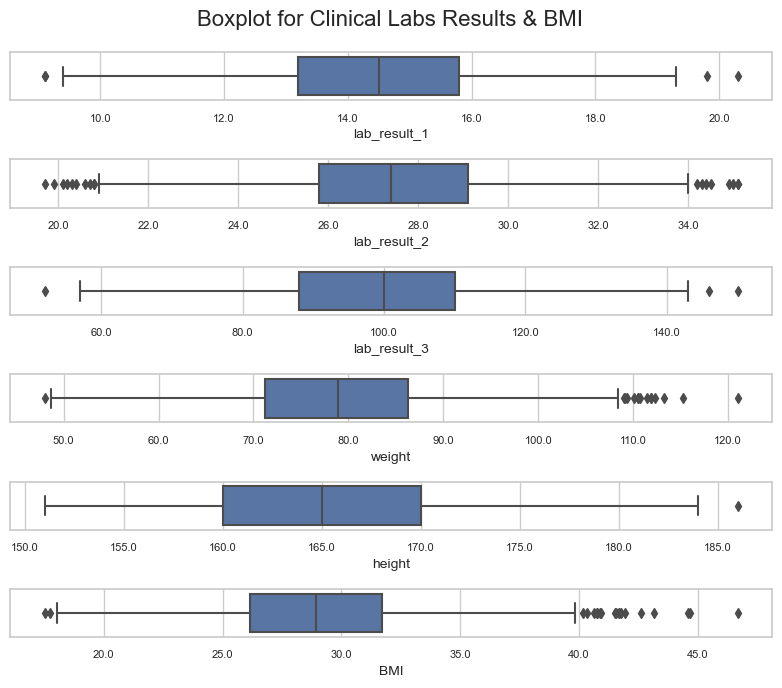

In [82]:
# Select the columns to analyze
columns = ['lab_result_1', 'lab_result_2', 'lab_result_3', 'weight', 'height', 'BMI']

# Create box plots for each column
fig, axs = plt.subplots(6, 1, figsize=(8, 7))
for i in range(6):
    ax = axs[i]
    column = columns[i]
    sns.boxplot(data=merged_df, x=column, ax=ax)
    ax.set_xlabel(column, fontsize=10)
    ax.set_xticklabels(ax.get_xticks(), fontsize=8)
fig.suptitle('Boxplot for Clinical Labs Results & BMI', fontsize=16)
plt.tight_layout()
plt.show();

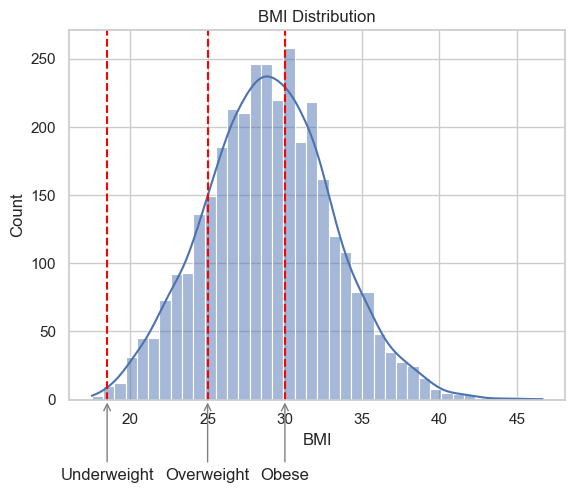

In [83]:
# Plot the histogram
ax = sns.histplot(data = merged_df,
                  x = 'BMI',
                 kde=True)

# Add labels and title to the plot
plt.xlabel('BMI')
plt.ylabel('Count')
plt.title('BMI Distribution')

ax.axvline(x=18.5, color='red', linestyle='--')
ax.axvline(x=25, color='red', linestyle='--')
ax.axvline(x=30, color='red', linestyle='--')

# Annotate the lines
ax.annotate('Underweight', xy=(18.5, 0), xytext=(18.5, -50),
            arrowprops=dict(facecolor='grey', arrowstyle='->', color='grey'),
            ha='center', va='top')
ax.annotate('Overweight', xy=(25, 0), xytext=(25, -50),
            arrowprops=dict(facecolor='grey', arrowstyle='->', color='grey'),
            ha='center', va='top')
ax.annotate('Obese', xy=(30, 0), xytext=(30, -50),
            arrowprops=dict(facecolor='grey', arrowstyle='->', color='grey'),
            ha='center', va='top')


# Display the plot
plt.show();

**Comment**<br>


|Observation|Remarks|
|---|---|
|*`LAB RESULTS`*<br><br> There is some outliers reflected in the boxplot|It is not appropriate whether lab results are in healthy range or not without understanding what are these lab results specifically.<br>As such we will leave the data as it is and examine subsequently if it has any apparent association with hospitalisation bill|
|*`HEIGHT, WEIGHT, BMI`*<br><br>Most of the patients do not have healthy body weight|<li>Minimum BMI was 17.5<li>Maximum BMI was 46.7<li>25th percentile is 26.2 <li> We can infer that approximately 80% of the patient do not have healthy body weight during hospitalisation, with most of them being overweight/obese.|

#### 3.1.3.2 `History`,`Symptoms` and `Medications`

We will be examining the total number of med-histories, symptoms and medications a patient had during hospitalisation by creating new columns.<br>
We will also be examining the prevalence of each med-histories, symptoms and medications throughout hospitalisation cases from 2011-2015.

In [84]:
#list of three new columns
sums_col = ['sum_medical_history','sum_symptoms','sum_medications']
filters = ['history','symptom','medication']
for i in range(3):
    _filter = filters[i]
    new_col_name = sums_col[i]
    
    #obtain list of relevant columns
    _col = [col for col in merged_df.columns if _filter in col]
    
    #Create the new sum column
    merged_df[new_col_name] = 0
    merged_df[new_col_name] = merged_df[_col].sum(axis=1)
    
    #check the new column
    _col = [col for col in merged_df.columns if _filter in col]
    merged_df[_col].head(10)

,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,sum_medical_history
0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,1,1
3,0,1,0,0,0,1,1,3
4,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,1
6,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,1
8,0,0,0,1,0,0,0,1
9,0,0,0,0,0,1,1,2


,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,sum_symptoms
0,0,0,1,1,1,3
1,0,0,0,1,1,2
2,1,1,0,1,0,3
3,1,1,1,1,1,5
4,1,1,1,1,0,4
5,0,1,0,1,0,2
6,1,0,1,1,1,4
7,1,1,0,0,0,2
8,0,1,1,1,0,3
9,0,1,0,1,0,2


,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,sum_medications
0,0,1,1,1,1,0,4
1,1,0,1,0,0,1,3
2,0,1,1,0,1,1,4
3,1,0,1,0,0,1,3
4,0,1,1,1,1,1,5
5,0,1,1,1,1,0,4
6,0,1,1,1,1,1,5
7,0,0,1,0,1,1,3
8,0,1,1,1,1,1,5
9,0,0,0,0,1,0,1


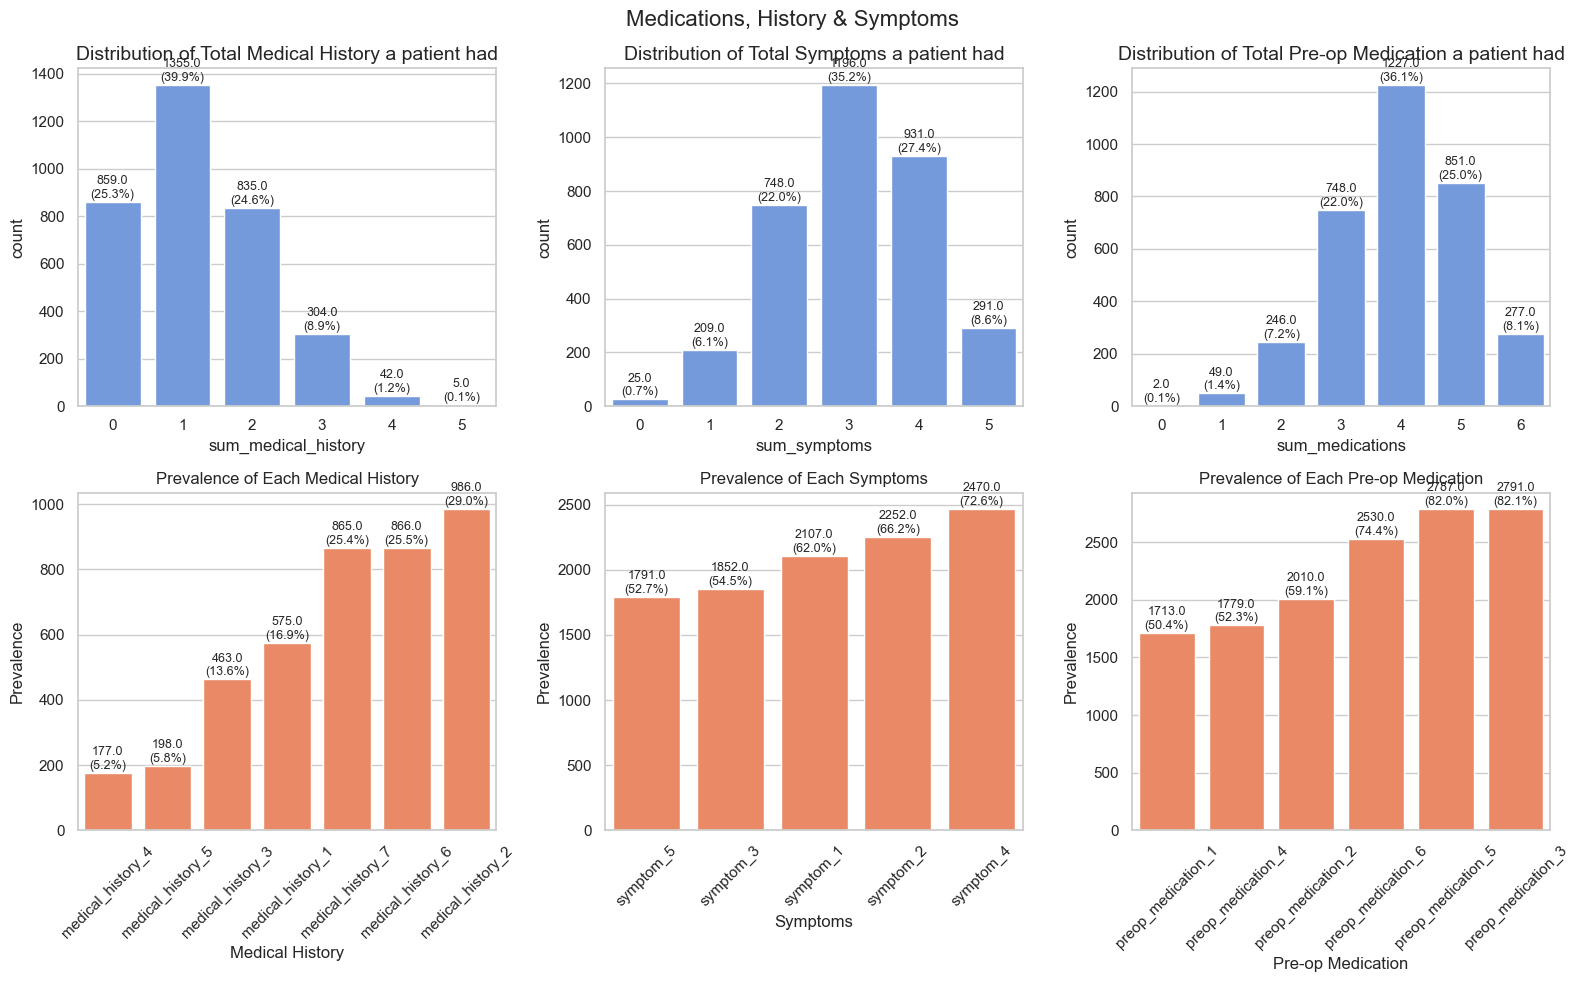

In [114]:
counts = []

_col = [col for col in merged_df.columns if 'history_' in col]
med_hx_count = merged_df[_col].sum().sort_values()
counts.append(med_hx_count)

_col = [col for col in merged_df.columns if 'symptom_' in col]
sx_count = merged_df[_col].sum().sort_values()
counts.append(sx_count)


_col = [col for col in merged_df.columns if 'preop' in col]
med_count = merged_df[_col].sum().sort_values()
counts.append(med_count)

#Subplot Title list
title_ls = [
"Medical History",
'Symptoms',
'Pre-op Medication'
]


# Create a figure with 6 subplots
fig, axs = plt.subplots(2,3, figsize=(16,10))

for i in range(3):
    total_cases = len(merged_df)
    cnt = counts[i]
    x_ = sums_col[i] #list from prev cell
    sub_plot_title = title_ls[i]
    
    #Left subplot
    ax_left = axs[0,i]
    sns.countplot(data=merged_df,
              x=x_,
              color= 'cornflowerblue',
              ax=ax_left)
    ax_left.set_title(f"Distribution of Total {sub_plot_title} a patient had",fontsize = 14)
    
    # Add annotations to the left subplot
    
    for p in ax_left.patches:
        count = p.get_height()
        percentage = count / total_cases * 100
        ax_left.annotate(f'{count}\n({percentage:.1f}%)',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center',
                         xytext=(0, 10),
                         textcoords='offset points',
                         fontsize = 9)
        
    # Right subplot
    ax_right = axs[1,i]
    sns.barplot(x=cnt.index,
                y=cnt.values,
                color = 'coral',
                ax=ax_right)
    ax_right.set_xlabel(sub_plot_title)
    ax_right.set_ylabel('Prevalence')
    ax_right.set_title(f'Prevalence of Each {sub_plot_title}',fontsize = 12)
    ax_right.set_xticklabels(ax_right.get_xticklabels(), rotation=45)  # Rotate x-axis labels if needed

    # Add annotations to the barplot
    for p in ax_right.patches:
        count = p.get_height()
        percentage = count / total_cases * 100
        ax_right.annotate(f'{count}\n({percentage:.1f}%)',
                          (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha='center', va='center',
                          xytext=(0, 10),
                          textcoords='offset points',
                          fontsize = 9)



#Title
fig.suptitle('Medications, History & Symptoms', fontsize=16)
# Adjust the spacing between subplots
plt.tight_layout()
# Display the combined plot
plt.show();

**Comments**<br>
||Observation|Description|
|---|---|---|
|Medical History|`Number of medical history:`<br><li>Most hospitalisation cases have patient with at least one medical history<li>Some hospitalisation cases have patient with multiple medical history<li>Observed highest number of medical history is 5 out of 7.|<li>About 75% of hospitalisation cases have patient with at least one medical history during hospitalisation<li> About 35% of hospitalisation cases have patient with multiple medical history, with about 1.5% having as many as 4 or 5.|
||`Prevalence of each medical history` <br><li> Higher prevalence medical histories are `2`, `6` & `7`<li>Least prevalence medical histories are `4` & `5`.|<li> Medical histories are `2`, `6` & `7` seen in >25%  of hospitalisation cases<li>Medical histories are `4` & `5` seen in about 5% of the hospitalisation cases.|
|Syptoms|`Number of symptoms:`<br><br><li>Most hospitalisation cases have patient with at least 3 symptoms<li>Observed highest number of medical history is 5.|<li>About 70% of hospitalisation cases have patient with at least 3 symptoms<li> About 9% of hospitalisation cases have patient with 5 symptoms.|
||`Prevalence of each medical history:`<br><br><li> Highest prevalence seen for `symptom_4`<li>Least prevalence symptoms are `3` & `5`.|<li>`symptom_4` observed in 72.6%  of hospitalisation cases<li>Symptoms `3` & `5` seen in about 50-55% of the hospitalisation cases.|
|Medications|`Number of pre-op meds:`<br><br><li>Most hospitalisation cases have patient with at least 4 pre-op medications<li>Observed highest number of pre-op medications is 6.|<li>About 70% of hospitalisation cases have patient with at least 4 pre-op medications<li> About 8% of hospitalisation cases have patient with 5 pre-op medications.|
||`Prevalence of each pre-op med:`<br><br><li> Highest prevalence pre-op med observed were `5` and `3`<li>Least prevalence symptoms are `1` & `4`.|<li>Pre-op med `3` and `5` observed in >80%  of hospitalisation cases<li>Pre-op med `1` and `4` observed in about 50% of the hospitalisation cases.


### SUMMARY OF UNIVARIATE ANALYSIS

**TOTAL BILL PER HOSPITALISATION**

- Does not follow normal distribution
- The bill ranges from \~\\$2.9K to \~\\$99K.
- Average bill is about \\$20K.
- 2.8% of the bill is very large and are outliers (\>\\$44.5K)"


**DEMOGRAPHIC**<br>
Demographic analysis show similar distributions when analysis conducted across 3000 unique patients and 3400 hospitalisation case.<br><br>
|Feature|Observation|Remarks|
|---|---|---|
|Gender|Relatively balanced (50.1% : 49.9%)||
|Race|Chinese appears to be dominant racial group (63.7%)|Racial profile may influence hospitalisation bill because:<br><li>Difference ethinicities predispose individuals to certain medical conditions ([reference](https://www.singhealth.com.sg/news/tomorrows-medicine/new-study-uncovers-genetic-risks-of-getting-disease-among-different-ethnicities-in-singapore))<li>Hospitalisation bill is influenced by the treatment received for medical conditions<li>It is possible we may observe a particular ethnic group tend to have higher/lower bill as a result of particular disease conditions that the ethnic group tends to have.|
|Resident Status|Singapore citizen  appears to be dominant group (80.1%)|Resident status have influence on hospitalisation bill, as it determines if the individual is eligible for government subsidies ([reference](https://www.guidemesingapore.com/business-guides/immigration/get-to-know-singapore/healthcare-in-singapore))|
|Age|<li>Generally two main groups of patients (Younger between 22-55yo) and (Older 55-85yo)<li>Middle-aged patients (40s-mid60s) dominates over young(20s - 30s) and senior individuals (above 65yo)| We may observe older patients with more complicatios which will require more complex medical attentions|

**HOSPITAL ADMISSIONS & DURATION**
- Most patients had only 1 admission in 2011-2015, with about 13% with multiple admissions.
- Hospitalisation duration range from 1 day to 20 days.
- Most patients hospitalisation duration is around 1 to 2 weeks.
    
**CLINICAL**
- `Lab Results`: some outliers detected, but unable to comment further without understanding what are these lab results specifically
- `BMI`: Most of the patients do not have healthy body weight, mostly oerweight/obese
- 'MEDICAL HISTORY'
    - `Number of medical history:`<br><ul><li>Most hospitalisation cases have patient with at least one medical history<li>Some hospitalisation cases have patient with multiple medical history<li>Observed highest number of medical history is 5 out of 7.</ul>
    - `Prevalence of each medical history` <br><ul><li> Higher prevalence medical histories are `2`, `6` & `7`<li>Least prevalence medical histories are `4` & `5`.</ul>
- SYMPTOMS
    - `Number of symptoms:`<ul><li>Most hospitalisation cases have patient with at least 3 symptoms<li>Observed highest number of medical history is 5.</ul>
    - `Prevalence of each medical history:`<br><ul><li> Highest prevalence seen for `symptom_4`<li>Least prevalence symptoms are `3` & `5`.</ul>
- PRE-OP MEDICATION
    - `Number of pre-op meds:`<ul><li>Most hospitalisation cases have patient with at least 4 pre-op medications<li>Observed highest number of pre-op medications is 6.</ul>
    - `Prevalence of each pre-op med:`<ul><li>Highest prevalence pre-op med observed were 5 and 3<li>Least prevalence symptoms are 1 & 4.</ul>

## 3.2 Multivariate Analysis

Focusing on the association with hospitalisation bill.

In [86]:
categorical_col = ['gender', 'race', 'resident_status','had_prev_admission']+clinical_bool_col

quantitative_col = ['total_hosp_bill','Age_upon_admission', 'hospitalization_duration_days', 'sum_medical_history', 'sum_symptoms','sum_medications']+clinical_qty_col

In [87]:
#Columns that in list above
[col for col in merged_df.columns if col not in categorical_col+quantitative_col]

['patient_id', 'date_of_admission', 'date_of_discharge', 'date_of_birth']

In [88]:
# Check any repeated columns in the two lists
[col for col in categorical_col if col in quantitative_col]

[]

### 3.2.1 Hospital Bill VS Quantitative variables

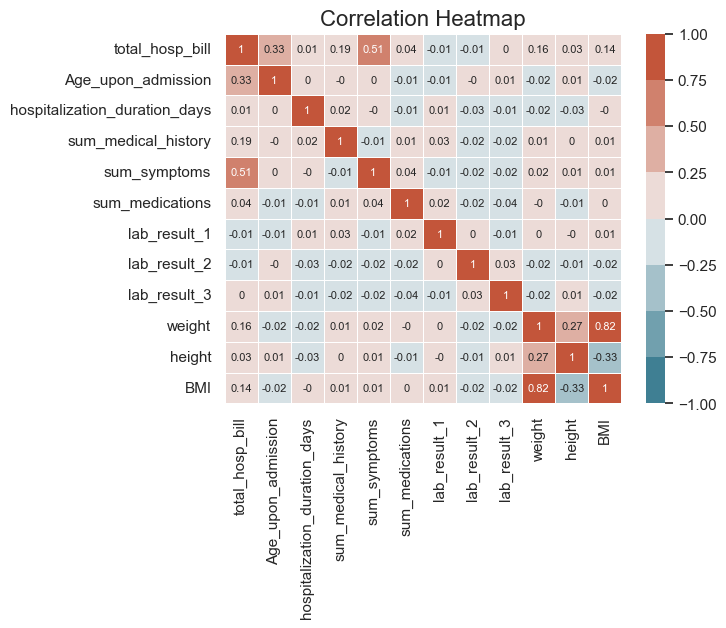

In [89]:
corr = merged_df[quantitative_col].corr(numeric_only=True).round(2)
sns.heatmap(corr,
            cmap = sns.diverging_palette(220, 20, n = 8),
            annot = True,
            annot_kws={"fontsize": 8},
            vmin = -1, vmax = 1,
            linewidths = 0.5);
plt.title("Correlation Heatmap",fontsize = 16);

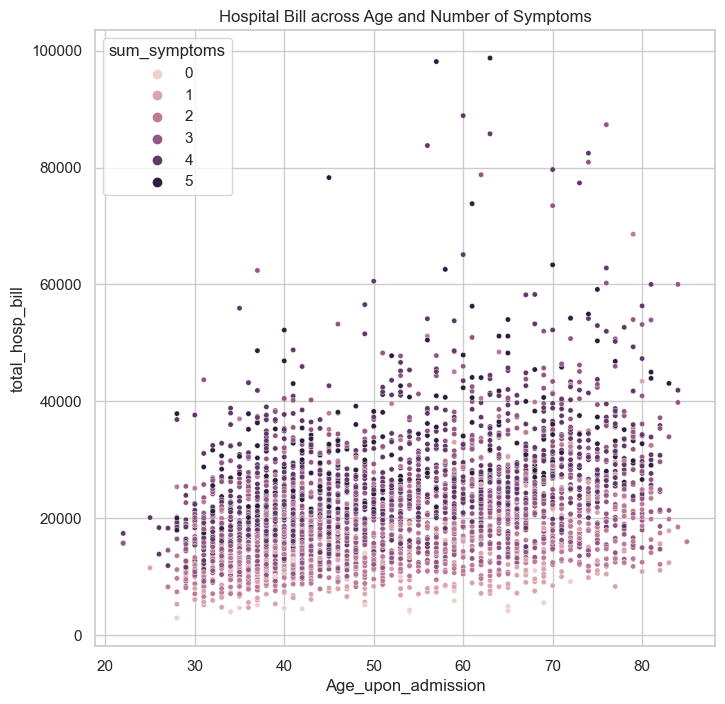

In [90]:
plt.figure(figsize = (8,8))
sns.scatterplot(data=merged_df,
               x = 'Age_upon_admission',
                y = 'total_hosp_bill',
               s =15,
                hue = 'sum_symptoms')
plt.title("Hospital Bill across Age and Number of Symptoms");

**COMMENTS**<br>
`Age_upo_admission` showed weak positive correlation with `total_hospital_bill`(r=0.33)<br>
`sum_symptoms` showed moderate positive correlation with `total_hospital_bill`(r=0.5)<br>
Other quantitative features does appear to have insignificant correlation with `r` close to 0

We can infer that patients older in age and patients with more symptoms tend to have higher hospital bill, likely due to greater medical care needed.

### 3.2.1 Hospital Bill VS Qualitative variables

In [91]:
categorical_col

['gender',
 'race',
 'resident_status',
 'had_prev_admission',
 'medical_history_1',
 'medical_history_2',
 'medical_history_3',
 'medical_history_4',
 'medical_history_5',
 'medical_history_6',
 'medical_history_7',
 'preop_medication_1',
 'preop_medication_2',
 'preop_medication_3',
 'preop_medication_4',
 'preop_medication_5',
 'preop_medication_6',
 'symptom_1',
 'symptom_2',
 'symptom_3',
 'symptom_4',
 'symptom_5']

In [92]:
from scipy.stats import mannwhitneyu

results = []  # List to store the results

for col in categorical_col:
    categories = merged_df[col].unique()  # Get unique categories in the column
    
    # Perform Mann-Whitney U test for each category against the others
    for i in range(len(categories)):
        for j in range(i+1, len(categories)):
            category1 = categories[i]
            category2 = categories[j]
            
            # Extract the bill values for each category
            category1_bills = merged_df.loc[merged_df[col] == category1, 'total_hosp_bill']
            category2_bills = merged_df.loc[merged_df[col] == category2, 'total_hosp_bill']
            
            # Perform the Mann-Whitney U test
            statistic, p_value = mannwhitneyu(category1_bills, category2_bills)
            
            # Store the result as a tuple (category1, category2, p-value)
            result = (col,category1, category2, p_value.round(5))
            results.append(result)

# Create a dataframe to display the results
results_df = pd.DataFrame(results, columns=['Column_name','Category 1', 'Category 2', 'p-value'])

In [93]:
results_df = results_df.sort_values(by = 'p-value')
results_df.reset_index(drop = True, inplace = True)
results_df

,Column_name,Category 1,Category 2,p-value
0,symptom_5,1,0,0.00000
1,race,Malay,Indian,0.00000
2,race,Malay,Chinese,0.00000
3,race,Malay,Others,0.00000
4,race,Indian,Chinese,0.00000
5,symptom_3,1,0,0.00000
6,symptom_2,0,1,0.00000
7,resident_status,Singapore citizen,PR,0.00000
8,resident_status,Singapore citizen,Foreigner,0.00000
9,resident_status,PR,Foreigner,0.00000


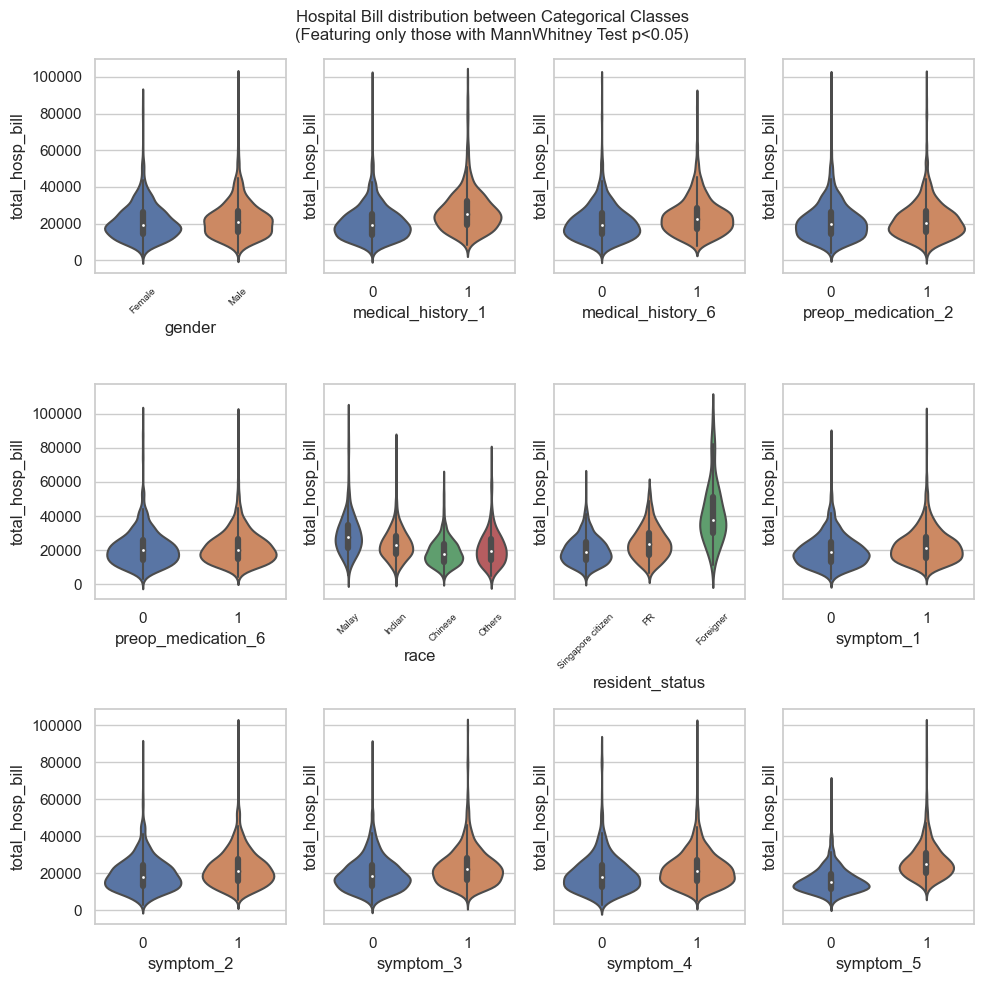

In [94]:
#Obtain a list of columns names where there is significant difference in hosp bill among the categorical class.
sig_results_df = results_df.loc[results_df['p-value']<0.05,:]
sig_cat_col = sorted(list(sig_results_df['Column_name'].unique()))

#Plot violin plots for these columns
fig, axs = plt.subplots(3,4,
                        figsize=(10, 10),
                       sharey = 'row')

axes = []
for i in range(3):
    for j in range(4):
        ax = axs[i, j]
        axes.append(ax)
        
for i in range(len(sig_cat_col)):
    sns.violinplot(data = merged_df,
                  y = 'total_hosp_bill',
                  x = sig_cat_col[i],
                  ax = axes[i])
    if sig_cat_col[i] in ['race','resident_status','gender']:
        axes[i].set_xticklabels(axes[i].get_xticklabels(),
                                rotation=45,
                               fontsize = 7)
    
fig.suptitle('Hospital Bill distribution between Categorical Classes\n(Featuring only those with MannWhitney Test p<0.05)', fontsize=12)

# Adjust the spacing between subplots
plt.tight_layout()
    
plt.show();

**COMMENT**
- Significant different in hospital bill distribution found among different gender, race and residential status
    - More evidently, from the violinplot, patient who were `foreigner` appear to have higher hospital bill
- Significant different in hospital bill distribution also found among patient with and without certain medical histories, pre-op medication and symptoms
    - More evidently, from the violinplot, patient with `symptom_5` appear to have higher hospital bill

# Part 4 Export data frame
## SUMMARY OF DATA PROCESSING
![](../images/data_processing_summary.jpg)

## Cleaned dataframe

In [95]:
merged_df.head()

,patient_id,date_of_admission,total_hosp_bill,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,...,race,resident_status,date_of_birth,Age_upon_admission,hospitalization_duration_days,had_prev_admission,BMI,sum_medical_history,sum_symptoms,sum_medications
0,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,23303.000924,2011-01-11,0,0,0,0,0,0,...,Malay,Singapore citizen,1978-07-20,33,10,0,30.625000,0,3,4
1,1d21f2be18683991eb93d182d6b2d220,2011-01-01,15405.418665,2011-01-11,0,1,0,0,0,0,...,Indian,Singapore citizen,1976-12-19,35,10,0,27.506655,1,2,3
2,79f52395dab0e6d3a03c48f765cb6562,2011-01-02,17153.905421,2011-01-18,0,0,0,0,0,0,...,Chinese,Singapore citizen,1936-04-05,75,16,0,29.958678,1,3,4
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,27994.878530,2011-01-14,0,1,0,0,0,1,...,Chinese,PR,1967-12-06,44,12,0,27.873961,3,5,3
4,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,16813.123088,2011-01-13,0,0,0,0,0,0,...,Indian,Singapore citizen,1967-08-14,44,11,0,31.577562,0,4,5


In [96]:
merged_df.to_csv("../data_output/cleaned_df", index = False)

## Lists of columns
- To be used in subsequent notebook for data filtering

In [97]:
unwanted_qty_col = [col for col in quantitative_col if ('lab' in col) or ('eight' in col) or ('bill' in col)]
subset_col_1 = [col for col in quantitative_col if col not in unwanted_qty_col] + sig_cat_col
subset_col_1

['Age_upon_admission',
 'hospitalization_duration_days',
 'sum_medical_history',
 'sum_symptoms',
 'sum_medications',
 'BMI',
 'gender',
 'medical_history_1',
 'medical_history_6',
 'preop_medication_2',
 'preop_medication_6',
 'race',
 'resident_status',
 'symptom_1',
 'symptom_2',
 'symptom_3',
 'symptom_4',
 'symptom_5']

In [98]:
subset_col_2 = sig_cat_col +['Age_upon_admission', 'sum_symptoms']
subset_col_2

['gender',
 'medical_history_1',
 'medical_history_6',
 'preop_medication_2',
 'preop_medication_6',
 'race',
 'resident_status',
 'symptom_1',
 'symptom_2',
 'symptom_3',
 'symptom_4',
 'symptom_5',
 'Age_upon_admission',
 'sum_symptoms']

In [99]:
quantitative_col

['total_hosp_bill',
 'Age_upon_admission',
 'hospitalization_duration_days',
 'sum_medical_history',
 'sum_symptoms',
 'sum_medications',
 'lab_result_1',
 'lab_result_2',
 'lab_result_3',
 'weight',
 'height',
 'BMI']

In [100]:
categorical_col

['gender',
 'race',
 'resident_status',
 'had_prev_admission',
 'medical_history_1',
 'medical_history_2',
 'medical_history_3',
 'medical_history_4',
 'medical_history_5',
 'medical_history_6',
 'medical_history_7',
 'preop_medication_1',
 'preop_medication_2',
 'preop_medication_3',
 'preop_medication_4',
 'preop_medication_5',
 'preop_medication_6',
 'symptom_1',
 'symptom_2',
 'symptom_3',
 'symptom_4',
 'symptom_5']

In [101]:
# Specify the file path where you want to save the dictionary
file_path_1 = '../data_output/subset_col_1_list.pkl'
file_path_2 = '../data_output/subset_col_2_list.pkl'
file_path_3 = '../data_output/qty_col_list.pkl'
file_path_4 = '../data_output/categorical_col_list.pkl'

ls_of_lists = [subset_col_1,subset_col_2,quantitative_col,categorical_col]
paths = [file_path_1,file_path_2,file_path_3,file_path_4]

# Load the list from the file using pickle
for i in range(4):
    ls_ = ls_of_lists[i]
    path = paths[i]
    with open(path, 'wb') as file:
        pickle.dump(ls_, file)